# Lab1: Regular expressions (aka regexps)

In [1]:
import collections
import os
import matplotlib.pyplot as plt
import re

In [2]:
BILL_DIRECTORY = '../files'

In [3]:
HEADER = r"u\s*s\s*t\s*a\s*w\s*a[\s\S]*?z\s*dnia\s*\d{1,2}\s*\w*\s*\d{4}"

def get_bill_files(directory):
    bills = collections.defaultdict(list)
    for root, _, files in os.walk(BILL_DIRECTORY):
        for file_name in files:
            path = os.path.join(root, file_name)
            with open(path) as file:
                date = re.findall(HEADER, file.read(), re.IGNORECASE)
                year = date[0][-4:] if date else os.path.splitext(file_name)[0].split('_')[0]
                bills[year] += [path]
    return bills

In [4]:
files = get_bill_files(BILL_DIRECTORY)
years = sorted(files.keys())

## 1. For each bill compute the number of the following amendments present in the bill:
* addition of a unit (e.g. **dodaje się ust. 5a**),
* removal of a unit (e.g. **w art. 10 ust. 1 pkt 8 skreśla się**),
* change of a unit (e.g. **art. 5 otrzymuje brzmienie**).

## 2. Note that other types of changes, e.g. **po wyrazach "na dofinansowanie" dodaje się wyrazy " , z zastrzeżeniem art. 21a,"**, must not be included in the result.

### Spostrzeżenia
* w kilku plikach zamiast cyfry `1` pojawiała się literka `l` (wygląda na to błąd OCR-a lub coś w tym rodzaju) -- przypadek ten został uwzgledniony,
* w kilku plikach występują błędy opierające się na braku symbolu `§` lub literówkach takich jak `art. art. 10b` -- przypadki te nie zostały uwzględnione.

### Rodzaje operacji
* **zmiania**: z reguły wyrażona jest frazą `otrzymuje brzmienie`, ale w jednym pliku pojawiła się też konstrukcja `nadać brzmienie`
    ```
    1) w art. 2:
       a) w ust. 1:
         - pkt 1 nadać brzmienie:
             "1) spółek handlowych (osobowych i kapitałowych, w tym również w
               organizacji) oraz spółek cywilnych, z zastrzeżeniem pkt 2, a także
               innych osób prawnych, z wyjątkiem Skarbu Państwa i Narodowego Banku
               Polskiego,",
    ```
* **usunięcie**: wyrażone frazą `uchyla się` lub `skreśla się`
* **dodanie**: wyrażone frazą `dodaje się`

W ustawach znajdują się również trudniejsze do zaklasfikowania fragmenty, z których kilka jest przedstawionych poniżej, jednak nie zostały one uwzględnione w tym zadaniu.
```
25) w art. 25:
    a) dotychczasowa treść otrzymuje oznaczenie ust. 1 i brzmienie:
      [...],
```
```
15) w art. 31:
    a) dotychczasową treść oznacza się jako ust. 1 i nadaje się jej brzmienie:
      [...],
```
```
    c) dotychczasowy ust. 3a oznacza się jako ust. 3b i nadaje mu brzmienie:
          [...];
```     

### Co zostało uwzględnione, chociaż nie powinno?

W związku z zastosowaniem dosyć ogólnego podejścia przedstawione rozwiązanie uwzględnia kilka nadmiarowych scenariuszy.

#### Modyfikacje jednostek wewnątrz cytatów

W korpusie występuje kilka przypadków, kiedy modyfikowany jest fragment dotyczący modyfikacji (choć odnoszę wrażenie, że nie jest to coś, co powinno mieć miejsce). Ze względu na fakt, że stosowane są wtedy zagnieżdżone cytaty (używające tego samego oznaczenia, `"`, niezależnie od poziomu zagłębienia cytatu), próba wykluczenia tych przypadków wydała mi się dosyć skomplikowana i fragmenty te również zostały zliczone.

    b) dodaje się pkt 3 i 4 w brzmieniu:
         "3) w art. 70b ust. 3 otrzymuje brzmienie:
            "3. Kolumna transportu sanitarnego podlega [...] uzyskuje osobowość prawną.";

    44) w art. 85 dodaje się pkt 13 w brzmieniu:
      "13) w art. 42 ust. 5 otrzymuje brzmienie:
         "5. Z dochodów uzyskanych [...] oraz zakupy inwestycyjne."".                                        

    11) w art. 48 pkt 3 otrzymuje brzmienie:
          "3) art. 53 otrzymuje brzmienie:
           "Art. 53. Księgi banków, wyciągi [...] oraz rejestrach publicznych." ";

Analiza oznaczeń cytatów wydała mi się nadmiernie skomplikowana nie tylko ze względu na liberalne podejście do zagnieżdżania, ale również w związku z występowaniem błędów takich jak fragment przedstawiony poniżej (gdzie znak `"` prawdopodobnie pojawił się w miejsce `-`).
    
    6) w art. 10:
       a) w ust. 1:
         " w pkt 1 skreśla się wyraz "również",
         " w pkt 3 skreśla się wyrazy "w tym również wykonywanie wolnego
           zawodu, z wyjątkiem działalności określonej w pkt 2,",
         " w pkt 6 na końcu dodaje się wyrazy "z wyjątkiem składników
           majątku związanych z działalnością gospodarczą,",
         " w pkt 7 wyrazy "sprzedaż i zamiana" zastępuje się wyrazami
           "odpłatne zbycie",
         [...]
    
#### Modyfikacje poprawnych jednostek w obrębie niepoprawnych jednostek

Z treści zadania zrozumiałam, że interesują nas fragmenty w formie:
* `w X Y otrzymuje brzmienie`,
* `w X skreśla się Y`,
* `w X dodaje się Y`,

gdzie zarówno `X`, jak i `Y` są [jednostkami redakcyjnymi](https://pl.wikipedia.org/wiki/Jednostka_redakcyjna_tekstu_prawnego). W związku z tym zależało mi na wykluczeniu fragmentów takich jak poniższy, w którym to dokonywana jest modyfikacja części załącznika (ani część, ani załącznik nie są jednostkami redakcyjnymi).

    W ustawie z dnia 9 września 2000 r. o opłacie skarbowej (Dz.U. Nr 86, poz. 960 oraz z 2001 r. Nr 5, poz. 43) w załączniku w części IV skreśla się pkt 16. 
    
Jednym z moich pomysłów było skupienie się na dopasowywaniu również części poprzedzającej `skreśla się` czy też `otrzymuje brzmienie`, jednak okazało się to dosyć problematyczne w kontekście wszelkiego rodzaju wyliczeń i zagnieżdżeń. Rozważałam użycie mechanizmu lookbehind, jednak zniechęcił mnie brak możliwości użycia wzorców o zmiennej długości. W poniższym cytacie dopasowanie takie musiałoby rozpoczynać się od `w art. 22` (lub nawet jeszcze wcześniej od wspomnienia ustawy) i chcielibyśmy uwzględnić `w art. 22 [...] ust. 1 otrzymuje brzmienie` oraz `w art. 22 [...] ust.3 otrzymuje brzmienie`. Nie ma jednak możliwości otrzymania kilku dopasowań zaczynających się od tego samego miejsca. W związku z tym zdecydowałam się na dopasowanie jedynie tej dodawanej lub usuwanej jednostki, niezależnie od tego, czy występuje w załączniku, czy też w jakimś artykule lub paragrafie.

    2) w art. 22:
       a) ust. 1 otrzymuje brzmienie:
         "1. Prawo do kwatery przysługuje żołnierzowi zawodowemu, o którym mowa w
           art. 21 ust. 1, od dnia rozpoczęcia pełnienia zawodowej służby wojskowej
           na podstawie kontraktu na pełnienie służby stałej.",
       b) uchyla się ust. 2,
       c) ust. 3 otrzymuje brzmienie:
         "3. Żołnierzom zawodowym pełniącym zawodową służbę wojskową na podstawie
           kontraktu na pełnienie służby stałej i innym osobom zajmującym
           kierownicze stanowiska w Ministerstwie Obrony Narodowej można
           przydzielić kwaterę funkcyjną na czas zajmowania określonego stanowiska
           służbowego. Do kwater tych nie stosuje się norm powierzchni mieszkalnej.
           Żołnierz otrzymujący kwaterę funkcyjną może zachować prawo do dotychczas
           zajmowanej kwatery. Przepisy art. 36 stosuje się odpowiednio.";

In [5]:
def count_occurences(regex, path, flags):
    with open(path) as file:
        return len(re.findall(regex, file.read(), flags=flags))

In [6]:
def get_distribution(pattern, files):
    distribution = collections.defaultdict(int)
    for year, files_for_year in files.items():
        for path in files_for_year:
            distribution[year] += count_occurences(pattern, path, re.MULTILINE)
    return distribution

Text(0.5, 1.0, 'Liczba modyfikacji jednostek na przestrzeni lat')

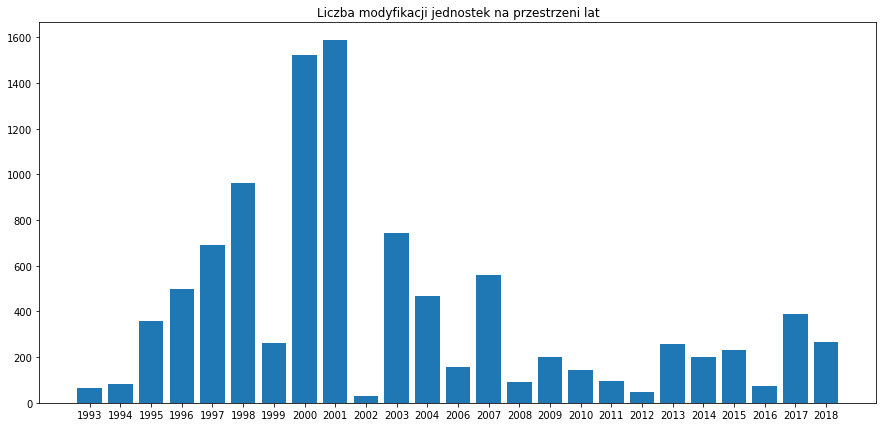

In [7]:
CHANGE_OF_UNIT = r'((art\.\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?'\
                     r'(\s*,\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)*'\
                     r'(\s*i\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)?)|'\
                 r'(§\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
                     r'(,\s*(§)?\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?))*'\
                     r'(\s*i\s*(§)?\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)?)|'\
                 r'(ust\.\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
                     r'(,\s*(ust\.)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)*'\
                     r'(\s*i\s*(ust\.)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)?)|'\
                 r'(pkt\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
                     r'(,\s*(pkt)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)*'\
                     r'(\s*i\s*(pkt)*\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)?)|'\
                 r'(lit\.\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?'\
                     r'(,\s*(lit\.)?\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?)*'\
                     r'(\s*i\s*(lit\.)?\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?)?))'\
                 r'\s*((otrzymuj[eą])|nadać)\s*brzmienie'

change_distribution = get_distribution(CHANGE_OF_UNIT, files)
        
plt.figure(figsize=(15, 7))
plt.bar(years, [change_distribution[year] for year in years])
plt.title('Liczba modyfikacji jednostek na przestrzeni lat')        

Text(0.5, 1.0, 'Liczba usuniętych jednostek na przestrzeni lat')

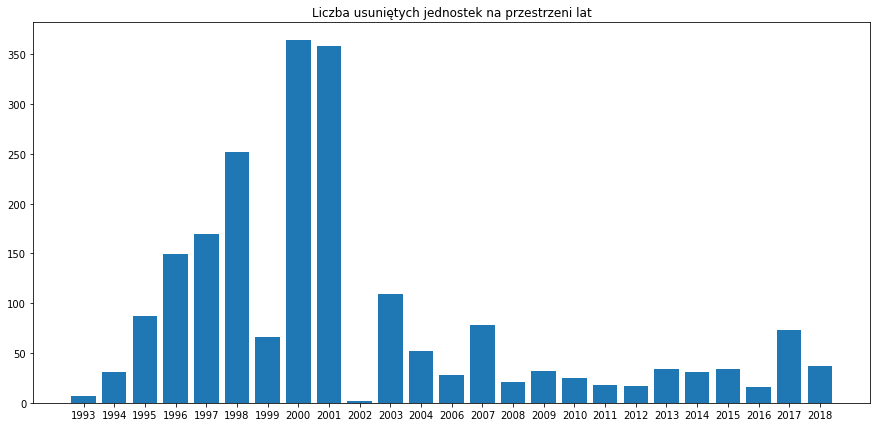

In [8]:
units =  r'((art\.\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?'\
             r'(\s*,\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)*'\
             r'(\s*i\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)?)|'\
         r'(§\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
             r'(,\s*(§)?\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?))*'\
             r'(\s*i\s*(§)?\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)?)|'\
         r'(ust\.\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
             r'(,\s*(ust\.)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)*'\
             r'(\s*i\s*(ust\.)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)?)|'\
         r'(pkt\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
             r'(,\s*(pkt)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)*'\
             r'(\s*i\s*(pkt)*\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)?)|'\
         r'(lit\.\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?'\
             r'(,\s*(lit\.)?\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?)*'\
             r'(\s*i\s*(lit\.)?\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?)?))'

removal = r'((uchyla|skreśla)\s*(się)?)'

REMOVAL_OF_UNIT = r'(' + removal + r'\s*' + units + r')|(' + units + r'\s*' + removal + r'[\.;,]' + r')'

removal_distribution = get_distribution(REMOVAL_OF_UNIT, files)
        
plt.figure(figsize=(15, 7))
plt.bar(years, [removal_distribution[year] for year in years])
plt.title('Liczba usuniętych jednostek na przestrzeni lat')        

Text(0.5, 1.0, 'Liczba dodanych jednostek na przestrzeni lat')

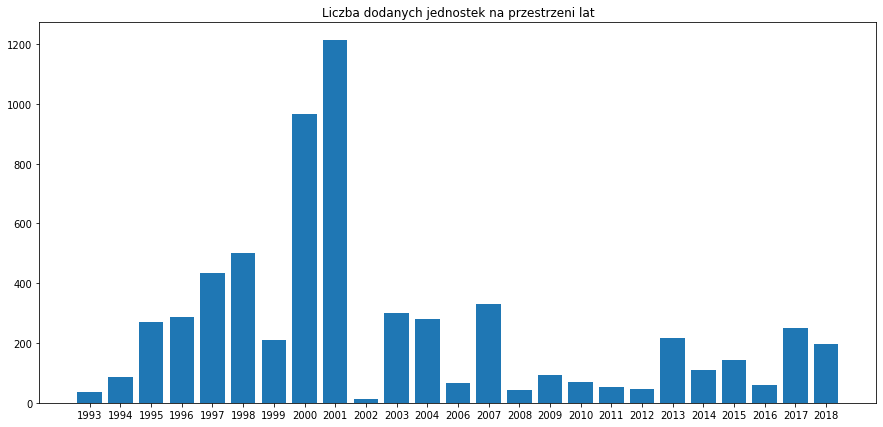

In [9]:
ADDITION_OF_UNIT = r'\s*dodaje\s*(się)?\s*'\
                   r'((art\.\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?'\
                       r'(\s*,\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)*'\
                       r'(\s*i\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)?)|'\
                   r'(§\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
                       r'(,\s*(§)?\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?))*'\
                       r'(\s*i\s*(§)?\s*[l\d]+[a-żA-Ż]*(\{\d+\})?(\s*[-–—]\s*[l\d]+[a-żA-Ż]*(\{\d+\})?)?)?)|'\
                   r'(ust\.\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
                       r'(,\s*(ust\.)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)*'\
                       r'(\s*i\s*(ust\.)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)?)|'\
                   r'(pkt\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?'\
                       r'(,\s*(pkt)?\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)*'\
                       r'(\s*i\s*(pkt)*\s*[l\d]+[a-żA-Ż]*(\s*[-–—]\s*[l\d]+[a-żA-Ż]*)?)?)|'\
                   r'(lit\.\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?'\
                       r'(,\s*(lit\.)?\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?)*'\
                       r'(\s*i\s*(lit\.)?\s*[a-żA-Ż]+\)?(\s*[-–—]\s*[a-żA-Ż]+\)?)?)?))'

addition_distribution = get_distribution(ADDITION_OF_UNIT, files)
        
plt.figure(figsize=(15, 7))
plt.bar(years, [addition_distribution[year] for year in years])
plt.title('Liczba dodanych jednostek na przestrzeni lat')        

## 3. Plot results from point 1 showing how the percentage of amendments of a given type changed in the consecutive years.

Text(0.5, 1.0, 'Procentowy udział rodzajów zmian')

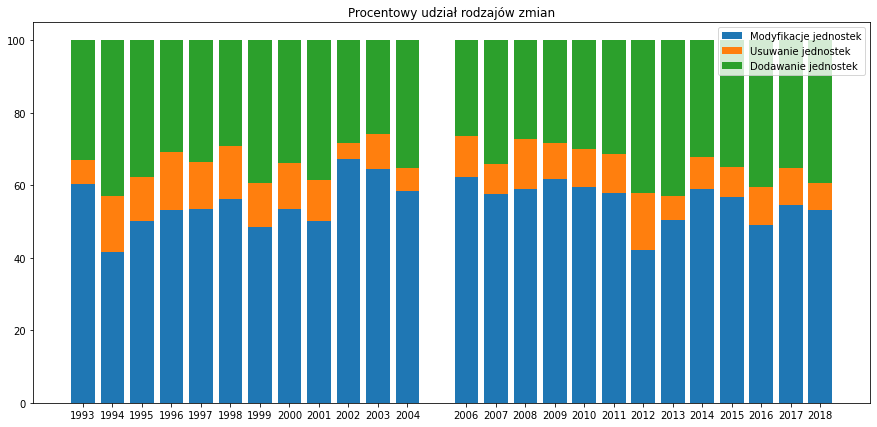

In [10]:
distribution = {year: change_distribution[year] + addition_distribution[year] + removal_distribution[year] for year in years}

plt.figure(figsize=(15,7))

x_axis = [int(year) for year in years]
y_axis_changes = [100 * change_distribution[year] / distribution[year] for year in years]
y_axis_removal = [100 * removal_distribution[year] / distribution[year] for year in years]
y_axis_addition = [100 * addition_distribution[year] / distribution[year] for year in years]

plt.bar(x_axis, y_axis_changes, label='Modyfikacje jednostek')
plt.bar(x_axis, y_axis_removal, label='Usuwanie jednostek', bottom=y_axis_changes)
plt.bar(x_axis, y_axis_addition, label='Dodawanie jednostek', bottom=[sum(y) for y in zip(y_axis_changes, y_axis_removal)])
plt.xticks(x_axis)
plt.legend()
plt.title('Procentowy udział rodzajów zmian')

## 4. Compute the total number of occurrences of the word ustawa in any inflectional form (*ustawa*, *ustawie*, *ustawę*, etc.) and all spelling forms (*ustawa*, *Ustawa*, *USTAWA*), excluding other words with the same prefix (e.g. *ustawić*).

Oprócz standardowych wystąpień słowa `ustawa` w korpusie pojawiają się również nietypowe wystąpienia z literami oddzielonymi spacjami.
```
                                  U S T A W A
                           z dnia 11 września 2003 r.
                                        
                    o służbie wojskowej żołnierzy zawodowych
```

In [11]:
pattern = r'(\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b)|(\s+u\s+s\s+t\s+a\s+w\s+a\s+)'
count = 0
for year, files_for_year in files.items():
    for path in files_for_year:
        count += count_occurences(pattern, path, flags=re.IGNORECASE | re.MULTILINE)
print(count)        

25233


## 5. Compute the total number of occurrences of the same word (same conditions), followed by **z dnia** expression.

In [12]:
pattern = r'((\bu\s*s\s*t\s*a\s*w\s*(a|y|ie|ę|ą|o|y|om|ami|ach)?\b)|(\s+u\s+s\s+t\s+a\s+w\s+a\s+))(?=\s*z\s*dnia\b)'
count_with_suffix = 0
for year, files_for_year in files.items():
    for path in files_for_year:  
        count_with_suffix += count_occurences(pattern, path, flags=re.IGNORECASE | re.MULTILINE)
print(count_with_suffix)

8779


## 6. As above, but **not** followed by **z dnia** expression. Is the result correct (result 4 =? result 5 + result 6)?

In [13]:
pattern = r'((\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b)|(\s+u\s+s\s+t\s+a\s+w\s+a\s+))(?!\s*z\s*dnia\b)'
count_without_suffix = 0
for year, files_for_year in files.items():
    for path in files_for_year:
        count_without_suffix += count_occurences(pattern, path, flags=re.IGNORECASE | re.MULTILINE)
print(count_without_suffix)

16454


In [14]:
count == count_with_suffix + count_without_suffix

True

## 7. Compute the total number of occurrences of the word **ustawa** in any inflectional form, excluding occurrences following **o zmianie** expression.

In [15]:
pattern = r'((\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b)|(\s+u\s+s\s+t\s+a\s+w\s+a\s+))(?!\s*o\s*zmianie\b)'
count_with_suffix_2 = 0
for year, files_for_year in files.items():
    for path in files_for_year:
        count_with_suffix_2 += count_occurences(pattern, path, flags=re.IGNORECASE | re.MULTILINE)
print(count_with_suffix_2)

25199


## 8. Plot results 4-7 using a bar chart.

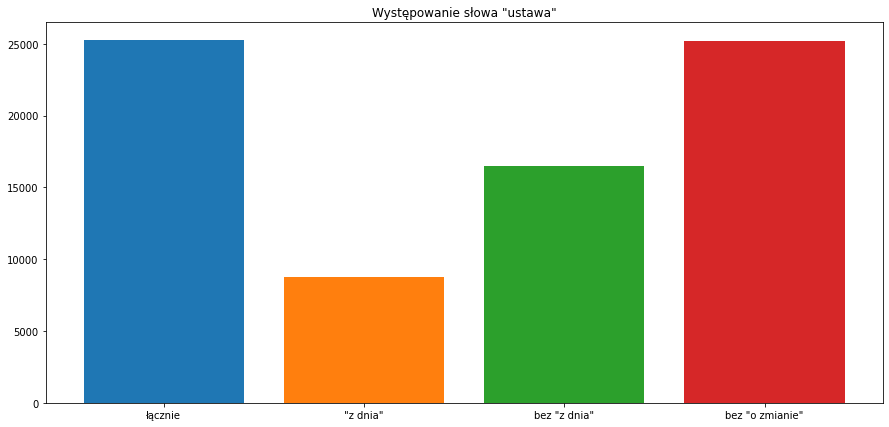

In [16]:
plt.figure(figsize=(15, 7))
plt.bar('łącznie', count)
plt.bar('"z dnia"', count_with_suffix)
plt.bar('bez "z dnia"', count_without_suffix)
plt.bar('bez "o zmianie"', count_with_suffix_2)
plt.title('Występowanie słowa "ustawa"')
plt.show()